In [3]:
import sys
sys.path.append('../input')
print(sys.path)

import os
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

# 设置随机种子以保持结果可复现性
np.random.seed(42)
tf.random.set_seed(42)

# 定义数据文件夹路径和类别标签
data_folder = "/kaggle/input/dna-sequence/DNA_sequence"
labels = ["chimpanzee", "dog", "human"]

# 读取DNA序列数据
sequences = []
class_labels = []
for label in labels:
    file_path = os.path.join(data_folder, label + ".txt")
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines[1:]:  # 跳过首行
            line = line.strip()
            sequence = line.split("\t")[0]  # 提取DNA序列部分
            sequences.append(sequence)
            class_labels.append(label)

# 将DNA序列转换为数值表示
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)

# 对序列进行填充，使其长度一致
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# 创建标签
labels = np.array([labels.index(label) for label in class_labels])

# 将数据集划分为训练集和测试集
num_samples = len(sequences)
indices = np.arange(num_samples)
np.random.shuffle(indices)
sequences = sequences[indices]
labels = labels[indices]
train_size = int(0.8 * num_samples)
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# 将标签进行独热编码
num_classes = len(labels)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/root/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/root/src/BigQuery_Helper', '../input', '../input']


In [4]:
# 使用GPU加速运算
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
# 转化类型适应CPU和GPU处理
train_sequences = torch.tensor(train_sequences).to(device)
test_sequences = torch.tensor(test_sequences).to(device)

train_labels = torch.tensor(train_labels).to(device)
test_labels = torch.tensor(test_labels).to(device)

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用的GPU设备编号
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # 启用GPU内存增长模式

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input

embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]
dropout_rate = 0.5

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # 嵌入层
    embedding = Embedding(len(tokenizer.word_index) + 1, embedding_dim)

    # 输入层
    inputs = Input(shape=(max_sequence_length,))

    # 应用嵌入层
    embedded_inputs = embedding(inputs)
    embedding_dropout = Dropout(dropout_rate)(embedded_inputs)

    # 添加多个不同尺寸的卷积层和池化层
    conv_blocks = []
    for filter_size in filter_sizes:
        conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation="relu")(embedding_dropout)
        conv_pooling = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv_pooling)

    # 合并卷积层的输出
    merged_output = tf.keras.layers.concatenate(conv_blocks, axis=-1)
    merged_output_dropout = Dropout(dropout_rate)(merged_output)

    # 全连接层
    hidden = Dense(128, activation="relu")(merged_output_dropout)

    # 输出层
    output = Dense(num_classes, activation="softmax")(hidden)

    # 构建模型
    model = Model(inputs=inputs, outputs=output)

    # 编译模型
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # 模型训练
    batch_size = 64
    epochs = 30

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.5388 - loss: 2.7792 - val_accuracy: 0.6623 - val_loss: 1.8956
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6164 - loss: 0.9250 - val_accuracy: 0.6623 - val_loss: 1.8491
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6163 - loss: 0.9196 - val_accuracy: 0.6623 - val_loss: 1.7727
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6158 - loss: 0.9105 - val_accuracy: 0.6623 - val_loss: 1.5396
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6106 - loss: 0.8964 - val_accuracy: 0.6623 - val_loss: 1.4353
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6094 - loss: 0.8787 - val_accuracy: 0.6623 - val_loss: 1.7581
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6096 - loss: 0.8718 - val_accuracy: 0.6623 - val_loss: 1.6844
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6087 - loss: 0

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.6112 - loss: 0.8495 - val_accuracy: 0.6623 - val_loss: 2.0185
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6168 - loss: 0.8487 - val_accuracy: 0.6623 - val_loss: 2.0930
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6127 - loss: 0.8451 - val_accuracy: 0.6623 - val_loss: 2.3409
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6168 - loss: 0.8395 - val_accuracy: 0.6623 - val_loss: 2.0985
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6177 - loss: 0.8388 - val_accuracy: 0.6623 - val_loss: 2.1263
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6148 - loss: 0.8372 - val_accuracy: 0.6623 - val_loss: 1.9602
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.6157 - loss: 0.8375 - val_accuracy: 0.6623 - val_loss: 1.9565
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.6171 - loss: 0

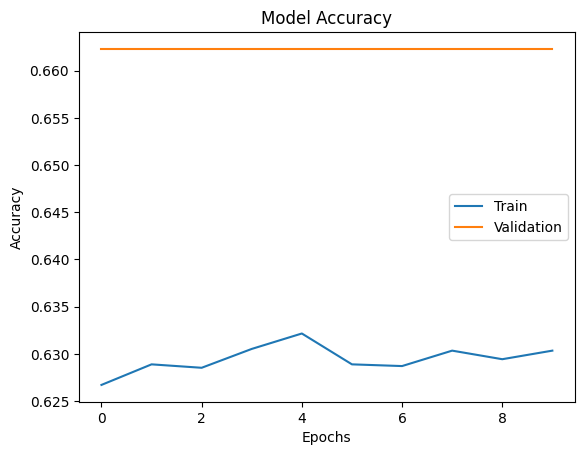

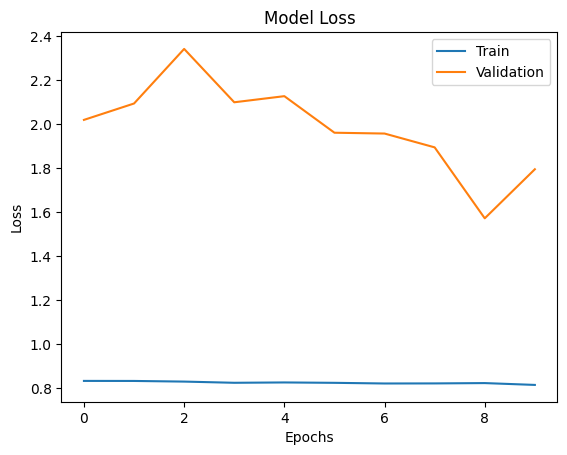

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6623 - loss: 1.7800
Test Accuracy: 0.6623093485832214
Model saved.


In [12]:
import matplotlib.pyplot as plt

# 模型训练
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels))

# 可视化评价指标
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 模型评估
_, accuracy = model.evaluate(test_sequences, test_labels, batch_size=batch_size)
print("Test Accuracy:", accuracy)

# 保存模型
model.save("my_model.h5")
print("Model saved.")